In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import psutil
import os
import time
import tracemalloc
import psutil
import sys
from pympler import asizeof
import matplotlib.pyplot as plt
from river import imblearn
from scipy.stats import ttest_rel
import itertools

from river import compose, preprocessing, metrics, stream, linear_model, evaluate
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import NearestNeighbors
from ALMASWA import ALMASWAClassifier

from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from Hamming import HammingLoss
import seaborn as sns
from tqdm import tqdm 

In [2]:
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign


In [3]:
print('Original dataset shape  %s' % Counter(data['Attack']))

Original dataset shape  Counter({'Reconnaissance': 470655, 'DDoS': 56844, 'DoS': 56833, 'Benign': 13859, 'Theft': 1909})


## Experiment 1: Comparing ALMA with ALMASWA on the complete dataset

In [20]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

--- ALMAClassifier ---
Accuracy: 0.9240
Recall: 0.9349
--- ALMASWAClassifier ---
Accuracy: 0.9821
Recall: 0.9945


## Experiment 2: Comparing ALMA with ALMASWA on different attack classes

### DDoS attack class

In [5]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT-DDoS.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'DDoS': 56844, 'Benign': 13859})
--- ALMAClassifier ---
Accuracy: 0.9870
Recall: 0.9923
--- ALMASWAClassifier ---
Accuracy: 0.9963
Recall: 0.9980


### DoS attack class

In [6]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT-DoS.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'DoS': 56833, 'Benign': 13859})
--- ALMAClassifier ---
Accuracy: 0.9876
Recall: 0.9926
--- ALMASWAClassifier ---
Accuracy: 0.9958
Recall: 0.9978


### Reconnaissance attack class

In [7]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT-Recon.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'Reconnaissance': 470655, 'Benign': 13859})
--- ALMAClassifier ---
Accuracy: 0.9496
Recall: 0.9626
--- ALMASWAClassifier ---
Accuracy: 0.9820
Recall: 0.9975


### Theft attack class

In [8]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT-Theft.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'Benign': 13859, 'Theft': 1909})
--- ALMAClassifier ---
Accuracy: 0.6586
Recall: 0.7627
--- ALMASWAClassifier ---
Accuracy: 0.8326
Recall: 0.9141


## Checking for features to use for introduction 

### Statistical characteristic of each feature. 

In [9]:
import pandas as pd

# Load data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)

# Compute statistical summaries
summary_stats = X.describe().T  # Compute mean, std, min, 25%, 50%, 75%, max
summary_stats['Skewness'] = X.skew()  # Add skewness
summary_stats['Kurtosis'] = X.kurt()  # Add kurtosis

# Print the numerical summaries
print("Feature Distribution Summary:")
print(summary_stats)

Feature Distribution Summary:
                               count          mean           std   min  \
L4_SRC_PORT                 600100.0  4.652890e+04  1.203639e+04   0.0   
L4_DST_PORT                 600100.0  7.949494e+03  1.410115e+04   0.0   
PROTOCOL                    600100.0  6.584854e+00  2.567061e+00   1.0   
L7_PROTO                    600100.0  8.956318e+00  3.496943e+01   0.0   
IN_BYTES                    600100.0  9.222368e+03  4.734768e+05  28.0   
OUT_BYTES                   600100.0  6.997822e+03  8.214194e+05   0.0   
IN_PKTS                     600100.0  1.243389e+01  2.460042e+02   1.0   
OUT_PKTS                    600100.0  5.696411e+00  1.914214e+02   0.0   
TCP_FLAGS                   600100.0  2.185652e+01  8.114914e+00   0.0   
FLOW_DURATION_MILLISECONDS  600100.0  3.468594e+06  1.665532e+06   0.0   

                                  25%        50%        75%          max  \
L4_SRC_PORT                   39180.0    47872.5    55307.0      65535.0   
L4_

### Statistical comparison of original and drift feature using the Kolmogorov-Smirnov test

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)

# Copy the dataset to avoid altering the original
X_drifted = X.copy()

# Parameters for noise
noise_mean = 0
noise_std = 0.2

# Introduce Gaussian noise into IN_BYTES and OUT_BYTES
X_drifted["IN_BYTES"] = X["IN_BYTES"] + np.random.normal(noise_mean, noise_std * X["IN_BYTES"].std(), size=len(X))
X_drifted["OUT_BYTES"] = X["OUT_BYTES"] + np.random.normal(noise_mean, noise_std * X["OUT_BYTES"].std(), size=len(X))

# Statistical comparison using the Kolmogorov-Smirnov test
results = {}
for feature in ["IN_BYTES", "OUT_BYTES"]:
    stat, p_value = ks_2samp(X[feature], X_drifted[feature])
    results[feature] = {"KS Statistic": stat, "P-Value": p_value}

print("Drift Analysis Results (Kolmogorov-Smirnov Test):")
print(results)

Drift Analysis Results (Kolmogorov-Smirnov Test):
{'IN_BYTES': {'KS Statistic': 0.49789535077487085, 'P-Value': 0.0}, 'OUT_BYTES': {'KS Statistic': 0.4988251958006999, 'P-Value': 0.0}}


## Experiment 3: Detection Accuracy Under Gradual Concept Drift

Creating data stream:   5%|▋            | 10054/200000 [00:27<08:33, 369.78it/s]


Evaluation at instance 10000:
ALMA - Accuracy: 0.9945, Recall: 0.9972
ALMASWA - Accuracy: 0.9927, Recall: 0.9988


Creating data stream:  10%|█▎           | 20051/200000 [00:54<08:04, 371.50it/s]


Evaluation at instance 20000:
ALMA - Accuracy: 0.9968, Recall: 0.9984
ALMASWA - Accuracy: 0.9807, Recall: 1.0000


Creating data stream:  15%|█▉           | 30048/200000 [01:18<06:57, 407.44it/s]


Evaluation at instance 30000:
ALMA - Accuracy: 0.9986, Recall: 0.9993
ALMASWA - Accuracy: 0.9974, Recall: 1.0000


Creating data stream:  20%|██▌          | 40078/200000 [01:42<06:34, 405.29it/s]


Evaluation at instance 40000:
ALMA - Accuracy: 0.9977, Recall: 0.9988
ALMASWA - Accuracy: 0.9969, Recall: 1.0000

Drift step 1: Increasing noise_std to 0.10


Creating data stream:  25%|███▎         | 50054/200000 [02:09<06:42, 372.11it/s]


Evaluation at instance 50000:
ALMA - Accuracy: 0.9866, Recall: 0.9872
ALMASWA - Accuracy: 0.9968, Recall: 1.0000


Creating data stream:  30%|███▉         | 60061/200000 [02:35<06:07, 381.04it/s]


Evaluation at instance 60000:
ALMA - Accuracy: 0.9309, Recall: 0.9318
ALMASWA - Accuracy: 0.9964, Recall: 1.0000


Creating data stream:  35%|████▌        | 70041/200000 [03:02<05:56, 364.35it/s]


Evaluation at instance 70000:
ALMA - Accuracy: 0.8390, Recall: 0.8396
ALMASWA - Accuracy: 0.9972, Recall: 1.0000


Creating data stream:  40%|█████▏       | 80052/200000 [03:27<05:27, 365.80it/s]


Evaluation at instance 80000:
ALMA - Accuracy: 0.9697, Recall: 0.9714
ALMASWA - Accuracy: 0.9665, Recall: 0.9919

Drift step 2: Increasing noise_std to 0.20


Creating data stream:  45%|█████▊       | 90053/200000 [03:53<05:18, 345.72it/s]


Evaluation at instance 90000:
ALMA - Accuracy: 0.9683, Recall: 0.9756
ALMASWA - Accuracy: 0.9722, Recall: 0.9914


Creating data stream:  50%|██████      | 100061/200000 [04:19<04:40, 356.48it/s]


Evaluation at instance 100000:
ALMA - Accuracy: 0.9718, Recall: 0.9740
ALMASWA - Accuracy: 0.9949, Recall: 1.0000


Creating data stream:  55%|██████▌     | 110063/200000 [04:45<03:58, 376.60it/s]


Evaluation at instance 110000:
ALMA - Accuracy: 0.9783, Recall: 0.9861
ALMASWA - Accuracy: 0.9779, Recall: 0.9997


Creating data stream:  60%|███████▏    | 120064/200000 [05:11<03:37, 366.73it/s]


Evaluation at instance 120000:
ALMA - Accuracy: 0.9646, Recall: 0.9687
ALMASWA - Accuracy: 0.9925, Recall: 1.0000

Drift step 3: Increasing noise_std to 0.30


Creating data stream:  65%|███████▊    | 130062/200000 [05:36<03:04, 378.49it/s]


Evaluation at instance 130000:
ALMA - Accuracy: 0.9869, Recall: 0.9926
ALMASWA - Accuracy: 0.9836, Recall: 1.0000


Creating data stream:  70%|████████▍   | 140045/200000 [06:02<02:33, 389.67it/s]


Evaluation at instance 140000:
ALMA - Accuracy: 0.9558, Recall: 0.9573
ALMASWA - Accuracy: 0.9964, Recall: 1.0000


Creating data stream:  75%|█████████   | 150081/200000 [06:56<02:07, 392.56it/s]


Evaluation at instance 150000:
ALMA - Accuracy: 0.9745, Recall: 0.9829
ALMASWA - Accuracy: 0.9800, Recall: 1.0000


Creating data stream:  80%|█████████▌  | 160052/200000 [07:20<01:38, 405.99it/s]


Evaluation at instance 160000:
ALMA - Accuracy: 0.9740, Recall: 0.9772
ALMASWA - Accuracy: 0.9945, Recall: 1.0000

Drift step 4: Increasing noise_std to 0.40


Creating data stream:  85%|██████████▏ | 170048/200000 [24:31<01:12, 412.26it/s]


Evaluation at instance 170000:
ALMA - Accuracy: 0.9709, Recall: 0.9777
ALMASWA - Accuracy: 0.9788, Recall: 1.0000


Creating data stream:  90%|██████████▊ | 180079/200000 [24:54<00:47, 415.08it/s]


Evaluation at instance 180000:
ALMA - Accuracy: 0.9757, Recall: 0.9790
ALMASWA - Accuracy: 0.9945, Recall: 1.0000


Creating data stream:  95%|███████████▍| 190047/200000 [25:19<00:25, 392.30it/s]


Evaluation at instance 190000:
ALMA - Accuracy: 0.9798, Recall: 0.9834
ALMASWA - Accuracy: 0.9699, Recall: 1.0000


Creating data stream: 100%|████████████| 200000/200000 [25:43<00:00, 129.62it/s]



Evaluation at instance 200000:
ALMA - Accuracy: 0.9641, Recall: 0.9709
ALMASWA - Accuracy: 0.9875, Recall: 1.0000


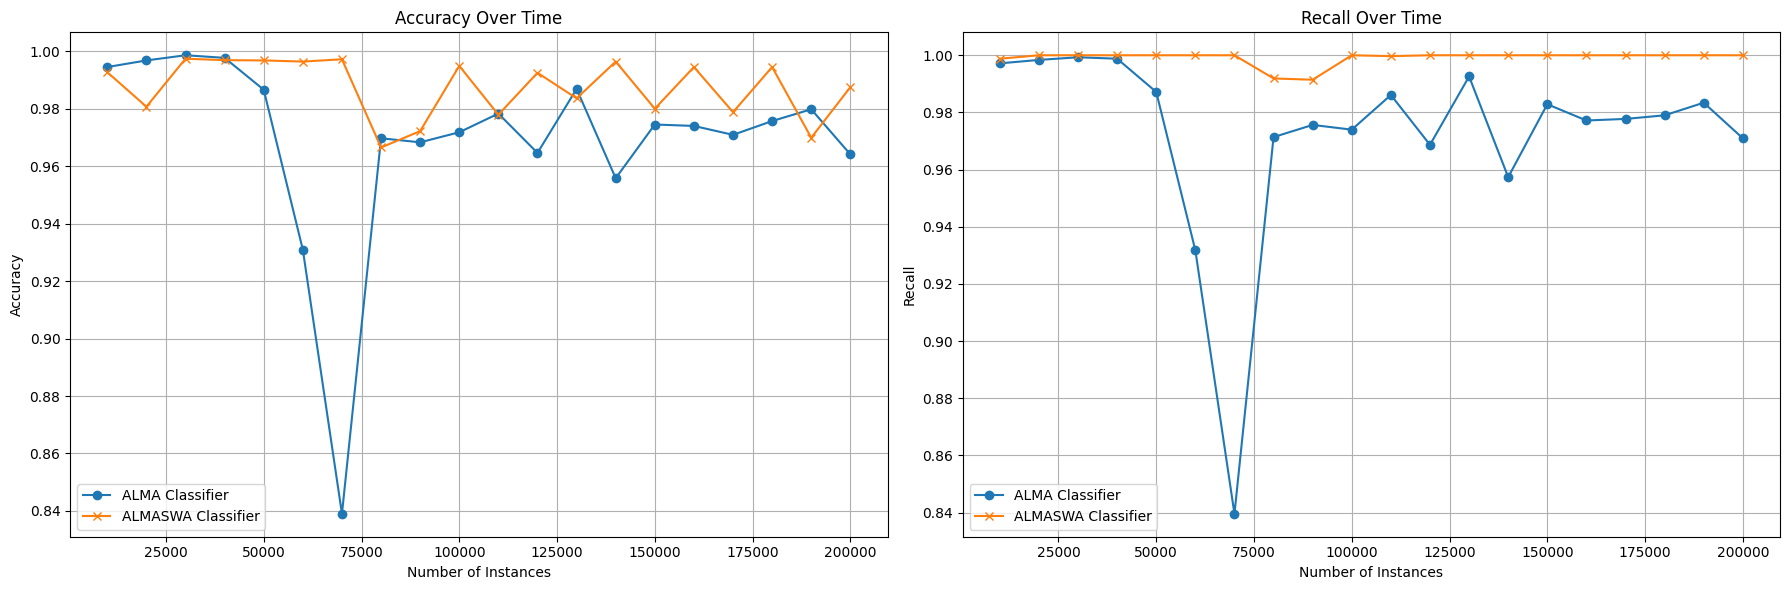

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import deque
from river import metrics
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")

# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label']]
X = data[feature_columns]
y = data['Label'] 

# Parameters for drift simulation
total_instances = 200000
drift_steps = 5
instances_per_drift = total_instances // drift_steps
initial_noise_std = 0.0
noise_increment = 0.10

def gradual_drift_stream(X, y, total_instances, drift_steps, instances_per_drift, 
                         noise_increment, feature_cols, target_col):
    """
    Generator that yields data instances with gradual concept drift.
    Noise is incrementally added to specified features every drift step.
    """
    current_noise_std = initial_noise_std
    for i in tqdm(range(total_instances), desc="Creating data stream"):
        if i > 0 and i % instances_per_drift == 0:
            current_noise_std += noise_increment
            print(f"\nDrift step {i // instances_per_drift}: Increasing noise_std to {current_noise_std:.2f}")
        
        # Apply noise to specified features
        instance = X.iloc[i].copy()
        instance["IN_BYTES"] += np.random.normal(0, current_noise_std * X["IN_BYTES"].std())
        instance["OUT_BYTES"] += np.random.normal(0, current_noise_std * X["OUT_BYTES"].std())
        
        label = y.iloc[i]
        yield instance.to_dict(), label

# Initialize classifiers
alma = linear_model.ALMAClassifier()
almaswa = ALMASWAClassifier()

# Metrics tracking
accuracy_alma = []
accuracy_almaswa = []
recall_alma = []
recall_almaswa = []
evaluation_points = []

window_size = 10000  # Sliding window size
slide_interval = 10000  # Evaluate every 10,000 instances

# Queues to store true labels and predictions
true_labels = deque(maxlen=window_size)
predictions_alma = deque(maxlen=window_size)
predictions_almaswa = deque(maxlen=window_size)

# Create the data stream
data_stream = gradual_drift_stream(
    X=X,
    y=y,
    total_instances=total_instances,
    drift_steps=drift_steps,
    instances_per_drift=instances_per_drift,
    noise_increment=noise_increment,
    feature_cols=feature_columns,
    target_col='Label'
)

# Iterate through the data stream
for i, (x, y_true) in enumerate(data_stream):
    # Make predictions before learning
    y_pred_alma = alma.predict_one(x)
    y_pred_almaswa = almaswa.predict_one(x)

    # Update the queues with true labels and predictions
    true_labels.append(y_true)
    predictions_alma.append(y_pred_alma)
    predictions_almaswa.append(y_pred_almaswa)

    # Learn from the current instance
    alma.learn_one(x, y_true)
    almaswa.learn_one(x, y_true)

    # Evaluate at each sliding window
    if (i + 1) % slide_interval == 0:
        # Initialize River's metrics
        acc_metric_alma = metrics.Accuracy()
        acc_metric_almaswa = metrics.Accuracy()
        rec_metric_alma = metrics.Recall()
        rec_metric_almaswa = metrics.Recall()

        # Update metrics for ALMA Classifier
        for true, pred in zip(true_labels, predictions_alma):
            acc_metric_alma.update(true, pred)
            rec_metric_alma.update(true, pred)
        
        # Update metrics for ALMASWA Classifier
        for true, pred in zip(true_labels, predictions_almaswa):
            acc_metric_almaswa.update(true, pred)
            rec_metric_almaswa.update(true, pred)

        # Append metrics
        evaluation_points.append(i + 1)
        accuracy_alma.append(acc_metric_alma.get())
        accuracy_almaswa.append(acc_metric_almaswa.get())
        recall_alma.append(rec_metric_alma.get())
        recall_almaswa.append(rec_metric_almaswa.get())

        # Print metrics
        print(f"\nEvaluation at instance {i + 1}:")
        print(f"ALMA - Accuracy: {acc_metric_alma.get():.4f}, Recall: {rec_metric_alma.get():.4f}")
        print(f"ALMASWA - Accuracy: {acc_metric_almaswa.get():.4f}, Recall: {rec_metric_almaswa.get():.4f}")

# Define the plotting function
def plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, 
                rec_alma, rec_almaswa):
    plt.figure(figsize=(18, 6))

    # Plot Detection Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(evaluation_points, accuracy_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, accuracy_almaswa, label='ALMASWA Classifier', marker='x')
    plt.xlabel('Number of Instances')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    # Plot F1-Score
    plt.subplot(1, 2, 2)
    plt.plot(evaluation_points, recall_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, recall_almaswa, label='ALMASWA Classifier', marker='x')
    plt.xlabel('Number of Instances')
    plt.ylabel('Recall')
    plt.title('Recall Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_Gradual_Drift.png')
    plt.show()

# Plot the metrics
plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, recall_alma, recall_almaswa)


# Experiment 4: Response to Sudden Concept Drift Events

Creating data stream:   5%|▋            | 10063/200000 [00:23<07:08, 443.04it/s]


Evaluation at instance 10000:
ALMA - Accuracy: 0.9945, Recall: 0.9972
ALMASWA - Accuracy: 0.9927, Recall: 0.9963

Baseline Accuracy (ALMA): 0.9945
Baseline Recall (ALMA): 0.9972
Baseline Accuracy (ALMASWA): 0.9927
Baseline Recall (ALMASWA): 0.9963


Creating data stream:  10%|█▎           | 20079/200000 [00:45<06:47, 441.88it/s]


Evaluation at instance 20000:
ALMA - Accuracy: 0.9968, Recall: 0.9984
ALMASWA - Accuracy: 0.9807, Recall: 0.9903


Creating data stream:  15%|█▉           | 30088/200000 [01:08<06:30, 435.61it/s]


Evaluation at instance 30000:
ALMA - Accuracy: 0.9986, Recall: 0.9993
ALMASWA - Accuracy: 0.9974, Recall: 0.9987


Creating data stream:  20%|██▌          | 40083/200000 [01:30<06:18, 422.18it/s]


Evaluation at instance 40000:
ALMA - Accuracy: 0.9977, Recall: 0.9988
ALMASWA - Accuracy: 0.9969, Recall: 0.9984


Creating data stream:  25%|███▎         | 50052/200000 [01:53<05:47, 431.30it/s]


Evaluation at instance 50000:
ALMA - Accuracy: 0.9988, Recall: 0.9994
ALMASWA - Accuracy: 0.9968, Recall: 0.9984
ALMA recovered at instance 50000
ALMASWA recovered at instance 50000

Sudden drift introduced at instance 50000


Creating data stream:  30%|███▉         | 60063/200000 [02:16<05:38, 412.84it/s]


Evaluation at instance 60000:
ALMA - Accuracy: 0.8931, Recall: 0.9434
ALMASWA - Accuracy: 0.9898, Recall: 0.9949


Creating data stream:  35%|████▌        | 70083/200000 [02:39<05:12, 415.78it/s]


Evaluation at instance 70000:
ALMA - Accuracy: 0.7843, Recall: 0.8789
ALMASWA - Accuracy: 0.8738, Recall: 0.9327


Creating data stream:  40%|█████▏       | 80087/200000 [03:01<04:26, 449.88it/s]


Evaluation at instance 80000:
ALMA - Accuracy: 0.9625, Recall: 0.9804
ALMASWA - Accuracy: 0.9585, Recall: 0.9788


Creating data stream:  45%|█████▊       | 90052/200000 [03:23<04:12, 436.04it/s]


Evaluation at instance 90000:
ALMA - Accuracy: 0.9675, Recall: 0.9833
ALMASWA - Accuracy: 0.9700, Recall: 0.9848


Creating data stream:  50%|██████      | 100092/200000 [03:45<03:42, 449.11it/s]


Evaluation at instance 100000:
ALMA - Accuracy: 0.9675, Recall: 0.9834
ALMASWA - Accuracy: 0.9865, Recall: 0.9932


Creating data stream:  55%|██████▌     | 110089/200000 [04:07<03:22, 444.85it/s]


Evaluation at instance 110000:
ALMA - Accuracy: 0.9780, Recall: 0.9887
ALMASWA - Accuracy: 0.9744, Recall: 0.9870


Creating data stream:  60%|███████▏    | 120057/200000 [04:29<03:16, 406.58it/s]


Evaluation at instance 120000:
ALMA - Accuracy: 0.9590, Recall: 0.9790
ALMASWA - Accuracy: 0.9843, Recall: 0.9921


Creating data stream:  65%|███████▊    | 130069/200000 [04:51<02:36, 447.56it/s]


Evaluation at instance 130000:
ALMA - Accuracy: 0.9877, Recall: 0.9937
ALMASWA - Accuracy: 0.9836, Recall: 0.9917


Creating data stream:  70%|████████▍   | 140080/200000 [05:13<02:14, 445.80it/s]


Evaluation at instance 140000:
ALMA - Accuracy: 0.9531, Recall: 0.9759
ALMASWA - Accuracy: 0.9957, Recall: 0.9978


Creating data stream:  75%|█████████   | 150094/200000 [05:35<01:50, 453.04it/s]


Evaluation at instance 150000:
ALMA - Accuracy: 0.9741, Recall: 0.9867
ALMASWA - Accuracy: 0.9781, Recall: 0.9889


Creating data stream:  80%|█████████▌  | 160050/200000 [05:56<01:28, 448.92it/s]


Evaluation at instance 160000:
ALMA - Accuracy: 0.9718, Recall: 0.9857
ALMASWA - Accuracy: 0.9905, Recall: 0.9952


Creating data stream:  85%|██████████▏ | 170056/200000 [06:18<01:07, 443.26it/s]


Evaluation at instance 170000:
ALMA - Accuracy: 0.9702, Recall: 0.9847
ALMASWA - Accuracy: 0.9775, Recall: 0.9886


Creating data stream:  90%|██████████▊ | 180054/200000 [06:40<00:44, 449.22it/s]


Evaluation at instance 180000:
ALMA - Accuracy: 0.9752, Recall: 0.9874
ALMASWA - Accuracy: 0.9929, Recall: 0.9964


Creating data stream:  95%|███████████▍| 190078/200000 [07:01<00:22, 450.36it/s]


Evaluation at instance 190000:
ALMA - Accuracy: 0.9803, Recall: 0.9898
ALMASWA - Accuracy: 0.9690, Recall: 0.9843


Creating data stream: 100%|████████████| 200000/200000 [07:23<00:00, 450.94it/s]



Evaluation at instance 200000:
ALMA - Accuracy: 0.9658, Recall: 0.9825
ALMASWA - Accuracy: 0.9828, Recall: 0.9913


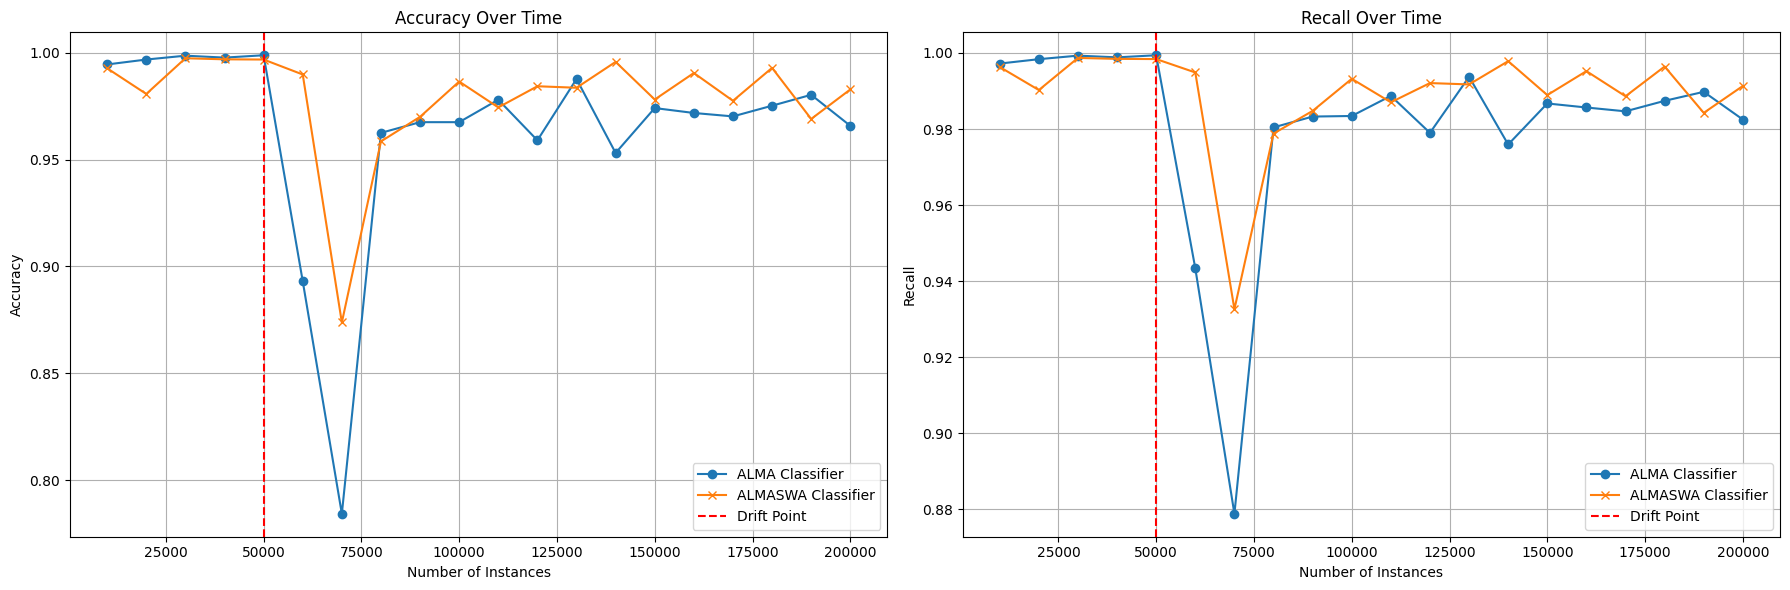

In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import deque
from river import metrics
import matplotlib.pyplot as plt

# ------------------------------
# Load and Prepare the Dataset
# ------------------------------

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")

# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label']]
X = data[feature_columns]
y = data['Label']  # Assuming 'Label' is the target variable

# ------------------------------
# Parameters for Drift Simulation
# ------------------------------

total_instances = 200000
drift_point = 50000  # Instance at which sudden drift occurs
noise_before_drift = 0.0
noise_after_drift = 0.8  # Increased noise to simulate sudden drift
noise_increment = 0.0  # Not used in sudden drift

# ------------------------------
# Data Stream Generator with Sudden Drift
# ------------------------------

def sudden_drift_stream(X, y, total_instances, drift_point, 
                        noise_before, noise_after, feature_cols, target_col):
    """
    Generator that yields data instances with a sudden concept drift.
    Noise is added to specified features at the drift point.
    """
    for i in tqdm(range(total_instances), desc="Creating data stream"):
        if i == drift_point:
            print(f"\nSudden drift introduced at instance {i}")
            current_noise_std = noise_after
        elif i < drift_point:
            current_noise_std = noise_before
        # After drift point, use increased noise
        else:
            current_noise_std = noise_after
        
        # Apply noise to specified features
        instance = X.iloc[i].copy()
        instance["IN_BYTES"] += np.random.normal(0, current_noise_std * X["IN_BYTES"].std())
        instance["OUT_BYTES"] += np.random.normal(0, current_noise_std * X["OUT_BYTES"].std())
        
        label = y.iloc[i]
        yield instance.to_dict(), label

# Initialize classifiers
alma = linear_model.ALMAClassifier()
almaswa = ALMASWAClassifier()

# ------------------------------
# Metrics Tracking Initialization
# ------------------------------

accuracy_alma = []
accuracy_almaswa = []
recall_alma = []
recall_almaswa = []
evaluation_points = []

window_size = 10000  # Sliding window size
slide_interval = 10000  # Evaluate every 10,000 instances

# Queues to store true labels and predictions
true_labels = deque(maxlen=window_size)
predictions_alma = deque(maxlen=window_size)
predictions_almaswa = deque(maxlen=window_size)

# Detection Delay Tracking
# Define baseline metrics before drift
baseline_accuracy = None
baseline_recall = None

# Threshold to consider recovery (95% of baseline)
recovery_threshold = 0.95

# Flags and counters
alma_recovered = False
almaswa_recovered = False
alma_recovery_point = None
almaswa_recovery_point = None

# ------------------------------
# Create the Data Stream
# ------------------------------

data_stream = sudden_drift_stream(
    X=X,
    y=y,
    total_instances=total_instances,
    drift_point=drift_point,
    noise_before=noise_before_drift,
    noise_after=noise_after_drift,
    feature_cols=feature_columns,
    target_col='Label'
)

# ------------------------------
# Iterate Through the Data Stream
# ------------------------------

for i, (x, y_true) in enumerate(data_stream):
    # Make predictions before learning
    y_pred_alma = alma.predict_one(x)
    y_pred_almaswa = almaswa.predict_one(x)

    # Update the queues with true labels and predictions
    true_labels.append(y_true)
    predictions_alma.append(y_pred_alma)
    predictions_almaswa.append(y_pred_almaswa)

    # Learn from the current instance
    alma.learn_one(x, y_true)
    almaswa.learn_one(x, y_true)

    # Evaluate at each sliding window
    if (i + 1) % slide_interval == 0:
        # Initialize River's metrics
        acc_metric_alma = metrics.Accuracy()
        acc_metric_almaswa = metrics.Accuracy()
        rec_metric_alma = metrics.F1()
        rec_metric_almaswa = metrics.F1()

        # Update metrics for ALMA Classifier
        for true, pred in zip(true_labels, predictions_alma):
            acc_metric_alma.update(true, pred)
            rec_metric_alma.update(true, pred)
        
        # Update metrics for ALMASWA Classifier
        for true, pred in zip(true_labels, predictions_almaswa):
            acc_metric_almaswa.update(true, pred)
            rec_metric_almaswa.update(true, pred)

        # Append metrics
        evaluation_points.append(i + 1)
        accuracy_alma.append(acc_metric_alma.get())
        accuracy_almaswa.append(acc_metric_almaswa.get())
        recall_alma.append(rec_metric_alma.get())
        recall_almaswa.append(rec_metric_almaswa.get())

        # Print metrics
        print(f"\nEvaluation at instance {i + 1}:")
        print(f"ALMA - Accuracy: {acc_metric_alma.get():.4f}, Recall: {rec_metric_alma.get():.4f}")
        print(f"ALMASWA - Accuracy: {acc_metric_almaswa.get():.4f}, Recall: {rec_metric_almaswa.get():.4f}")

        # Set baseline metrics before drift (first window before drift)
        if i + 1 == window_size and i + 1 < drift_point:
            baseline_accuracy = acc_metric_alma.get()
            baseline_recall = rec_metric_alma.get()
            print(f"\nBaseline Accuracy (ALMA): {baseline_accuracy:.4f}")
            print(f"Baseline Recall (ALMA): {baseline_recall:.4f}")
            baseline_accuracy_almaswa = acc_metric_almaswa.get()
            baseline_recall_almaswa = rec_metric_almaswa.get()
            print(f"Baseline Accuracy (ALMASWA): {baseline_accuracy_almaswa:.4f}")
            print(f"Baseline Recall (ALMASWA): {baseline_recall_almaswa:.4f}")

        # After drift, check for recovery
        if i + 1 >= drift_point:
            # ALMA Recovery Check
            if not alma_recovered and baseline_accuracy is not None:
                if acc_metric_alma.get() >= recovery_threshold * baseline_accuracy:
                    alma_recovered = True
                    alma_recovery_point = i + 1
                    print(f"ALMA recovered at instance {i + 1}")
            
            # ALMASWA Recovery Check
            if not almaswa_recovered and baseline_accuracy_almaswa is not None:
                if acc_metric_almaswa.get() >= recovery_threshold * baseline_accuracy_almaswa:
                    almaswa_recovered = True
                    almaswa_recovery_point = i + 1
                    print(f"ALMASWA recovered at instance {i + 1}")

# ------------------------------
# Define the Plotting Function
# ------------------------------

def plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, 
                recall_alma, recall_almaswa, drift_point, alma_recovery, almaswa_recovery):
    plt.figure(figsize=(18, 6))

    # Plot Detection Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(evaluation_points, accuracy_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, accuracy_almaswa, label='ALMASWA Classifier', marker='x')
    plt.axvline(x=drift_point, color='r', linestyle='--', label='Drift Point')
    # if alma_recovery:
    #     plt.axvline(x=alma_recovery, color='g', linestyle=':', label='ALMA Recovery')
    # if almaswa_recovery:
    #     plt.axvline(x=almaswa_recovery, color='b', linestyle=':', label='ALMASWA Recovery')
    plt.xlabel('Number of Instances')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    # Plot F1-Score
    plt.subplot(1, 2, 2)
    plt.plot(evaluation_points, recall_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, recall_almaswa, label='ALMASWA Classifier', marker='x')
    plt.axvline(x=drift_point, color='r', linestyle='--', label='Drift Point')
    plt.xlabel('Number of Instances')
    plt.ylabel('Recall')
    plt.title('Recall Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_Sudden_Drift.png')
    plt.show()

# ------------------------------
# Plot the Metrics
# ------------------------------

plot_metrics(
    evaluation_points, 
    accuracy_alma, 
    accuracy_almaswa, 
    recall_alma, 
    recall_almaswa, 
    drift_point=drift_point, 
    alma_recovery=alma_recovery_point, 
    almaswa_recovery=almaswa_recovery_point
)


## Experiment 5: Paired t-test using different seeds

In [13]:
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")

# Separate features (X) and label (y)
X_full = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y_full = data['Label']

# 2. We'll run 10 experiments, each with a different random seed
NUM_RUNS = 5
seeds = range(NUM_RUNS)  # e.g., 0 through 9

# We'll store final accuracy for each run
alma_accuracies = []
almaswa_accuracies = []

for seed in seeds:
    print(f"Running experiment with seed={seed} ...")
    
    # 2a. Shuffle data with this seed
    X, y = shuffle(X_full, y_full, random_state=seed)
    
    # 2b. Convert to a River stream
    data_stream = stream.iter_pandas(X, y)
    
    # 2c. Instantiate models & metrics
    model_alma = linear_model.ALMAClassifier()
    model_almaswa = ALMASWAClassifier()
    
    metric_alma = metrics.Accuracy()
    metric_almaswa = metrics.Accuracy()
    
    # 2d. Progressive learning/evaluation
    for x_dict, y_true in data_stream:
        # ALMA
        y_pred_alma = model_alma.predict_one(x_dict)
        metric_alma.update(y_true, y_pred_alma)
        model_alma.learn_one(x_dict, y_true)
        
        # ALMA+SWA
        y_pred_almaswa = model_almaswa.predict_one(x_dict)
        metric_almaswa.update(y_true, y_pred_almaswa)
        model_almaswa.learn_one(x_dict, y_true)
    
    # 2e. Collect final accuracies for this run
    alma_accuracies.append(metric_alma.get())
    almaswa_accuracies.append(metric_almaswa.get())
    
    print(f"  ALMA accuracy: {metric_alma.get():.4f}")
    print(f"  ALMA+SWA accuracy: {metric_almaswa.get():.4f}")
    print("")

# 3. Print summary of results
print("=== Summary of 10 Runs ===")
print("ALMA Accuracies   :", alma_accuracies)
print("ALMASWA Accuracies:", almaswa_accuracies)

print("\nMean ± Std for ALMA      : "
      f"{np.mean(alma_accuracies):.4f} ± {np.std(alma_accuracies):.4f}")
print("Mean ± Std for ALMA+SWA : "
      f"{np.mean(almaswa_accuracies):.4f} ± {np.std(almaswa_accuracies):.4f}")

# 4. (Optional) Significance test
#    Paired t-test over the 10 runs
t_stat, p_val = ttest_rel(alma_accuracies, almaswa_accuracies)
print(f"\nPaired t-test (ALMA vs ALMA+SWA): t_stat={t_stat:.4f}, p-value={p_val:.6f}")
if p_val <= 0.05:
    print("=> Statistically significant difference at alpha=0.05")
else:
    print("=> No statistically significant difference at alpha=0.05")

Running experiment with seed=0 ...
  ALMA accuracy: 0.9544
  ALMA+SWA accuracy: 0.9769

Running experiment with seed=1 ...
  ALMA accuracy: 0.9543
  ALMA+SWA accuracy: 0.9769

Running experiment with seed=2 ...
  ALMA accuracy: 0.9543
  ALMA+SWA accuracy: 0.9769

Running experiment with seed=3 ...
  ALMA accuracy: 0.9543
  ALMA+SWA accuracy: 0.9769

Running experiment with seed=4 ...
  ALMA accuracy: 0.9542
  ALMA+SWA accuracy: 0.9769

=== Summary of 10 Runs ===
ALMA Accuracies   : [0.9543676053991001, 0.9542726212297951, 0.9542976170638227, 0.9542659556740544, 0.954169305115814]
ALMASWA Accuracies: [0.9768971838026995, 0.9768955174137643, 0.9768971838026995, 0.9768855190801533, 0.9769005165805699]

Mean ± Std for ALMA      : 0.9543 ± 0.0001
Mean ± Std for ALMA+SWA : 0.9769 ± 0.0000

Paired t-test (ALMA vs ALMA+SWA): t_stat=-698.6088, p-value=0.000000
=> Statistically significant difference at alpha=0.05


## Experiment 6: Measuring Resource Usage

Number of samples per class: Counter({1: 586241, 0: 13859})
Processed 100000 samples. Throughput: 12690.47 samples/sec.
Processed 200000 samples. Throughput: 13331.43 samples/sec.
Processed 300000 samples. Throughput: 13545.57 samples/sec.
Processed 400000 samples. Throughput: 13421.69 samples/sec.
Processed 500000 samples. Throughput: 13643.73 samples/sec.
Processed 600000 samples. Throughput: 13819.78 samples/sec.

Total samples processed: 600100
Total elapsed time: 43.42 seconds
Throughput: 13819.24 samples/second

--- ALMAClassifier ---
Accuracy: 0.9240
Recall: 0.9349

--- ALMASWAClassifier ---
Accuracy: 0.9821
Recall: 0.9945

--- ALMAClassifier Performance ---
Average Latency per Sample: 0.0243 ms
Average CPU Usage: 1.08%
Average Memory Usage: -0.21 KB
Average Total Processing Time per Sample: 0.0341 ms

--- ALMASWAClassifier Performance ---
Average Latency per Sample: 0.0221 ms
Average CPU Usage: 1.08%
Average Memory Usage: -0.21 KB
Average Total Processing Time per Sample: 0.034

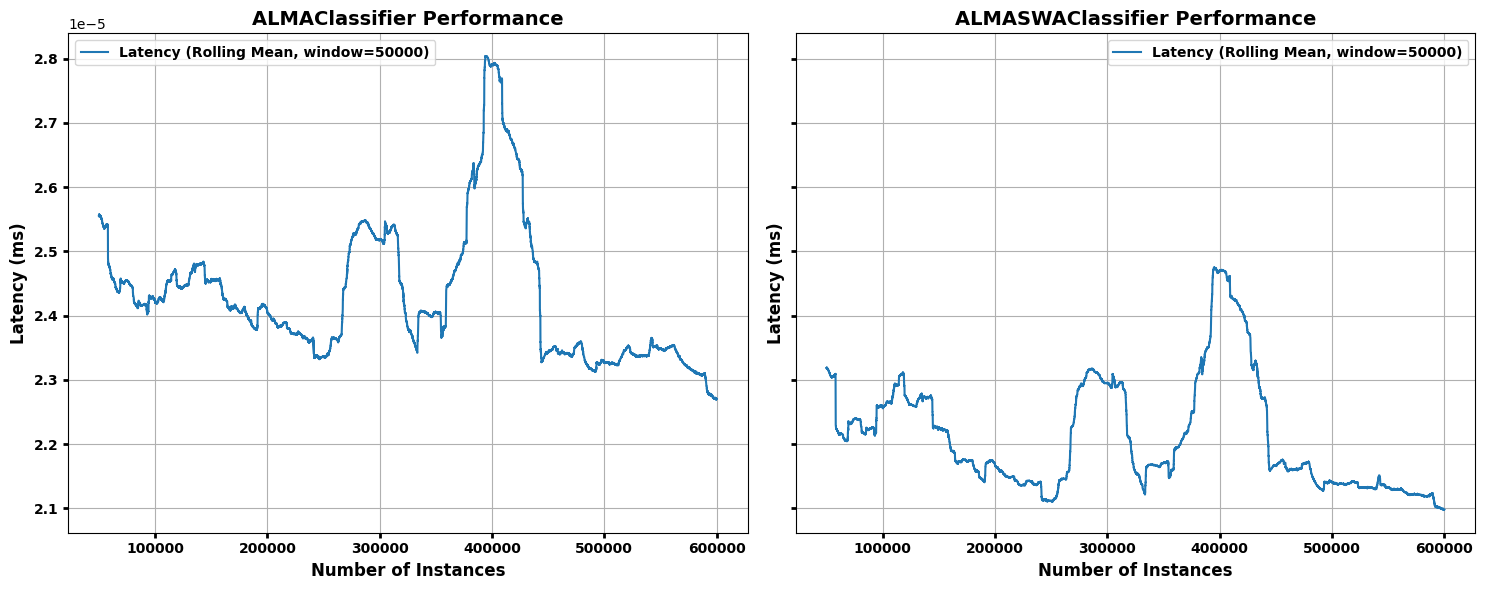

In [14]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=50000):
    metrics_names = ['Latency']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Latency (ms)', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_Latency.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### CPU Usage

Number of samples per class: Counter({1: 586241, 0: 13859})
Processed 100000 samples. Throughput: 11377.43 samples/sec.
Processed 200000 samples. Throughput: 11844.71 samples/sec.
Processed 300000 samples. Throughput: 12033.98 samples/sec.
Processed 400000 samples. Throughput: 12077.98 samples/sec.
Processed 500000 samples. Throughput: 12090.83 samples/sec.
Processed 600000 samples. Throughput: 12068.71 samples/sec.

Total samples processed: 600100
Total elapsed time: 49.73 seconds
Throughput: 12068.29 samples/second

--- ALMAClassifier ---
Accuracy: 0.9240
F1 Score: 0.9600
ROCAUC Score: 0.6970

--- ALMASWAClassifier ---
Accuracy: 0.9821
F1 Score: 0.9909
ROCAUC Score: 0.7273

--- ALMAClassifier Performance ---
Average Latency per Sample: 0.0240 ms
Average CPU Usage: 1.16%
Average Memory Usage: -0.11 KB
Average Total Processing Time per Sample: 0.0394 ms

--- ALMASWAClassifier Performance ---
Average Latency per Sample: 0.0220 ms
Average CPU Usage: 1.16%
Average Memory Usage: -0.11 KB
A

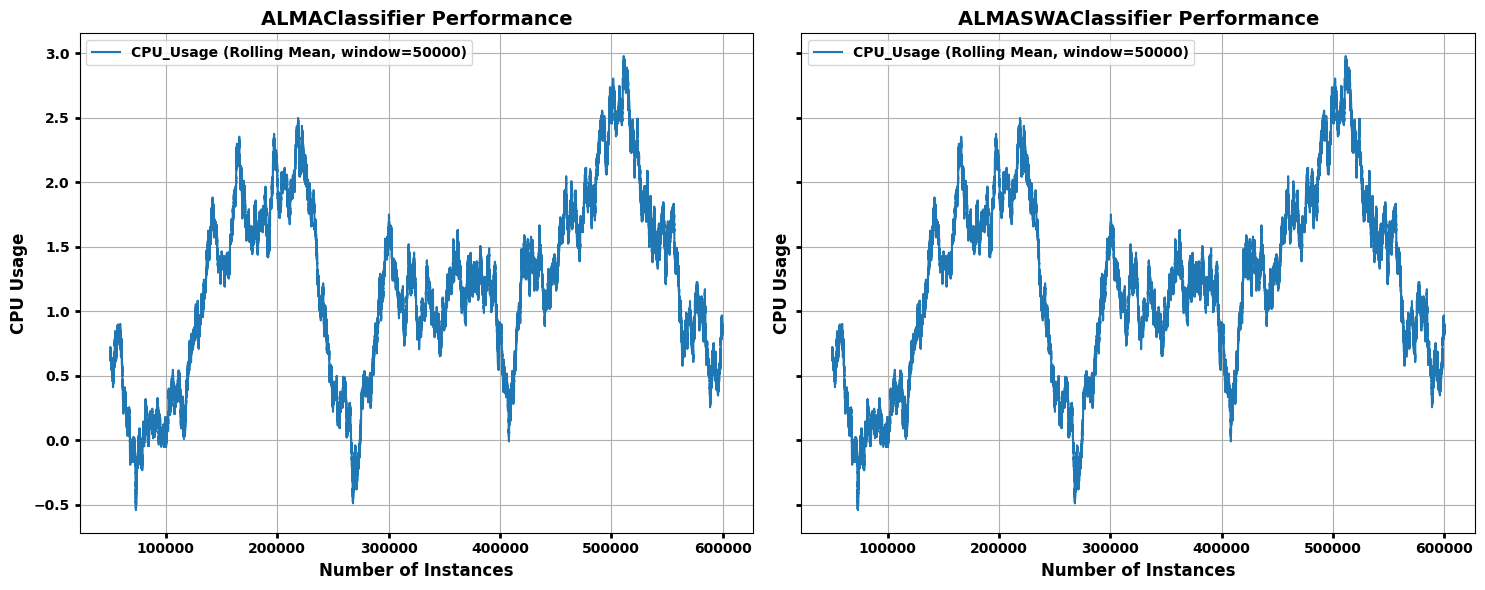

In [15]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=50000):
    metrics_names = ['CPU_Usage']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('CPU Usage', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_CPU.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### Memory usage

Number of samples per class: Counter({1: 586241, 0: 13859})
Processed 100000 samples. Throughput: 11335.21 samples/sec.
Processed 200000 samples. Throughput: 11810.20 samples/sec.
Processed 300000 samples. Throughput: 11835.20 samples/sec.
Processed 400000 samples. Throughput: 11693.07 samples/sec.
Processed 500000 samples. Throughput: 11790.83 samples/sec.
Processed 600000 samples. Throughput: 11889.41 samples/sec.

Total samples processed: 600100
Total elapsed time: 50.48 seconds
Throughput: 11889.00 samples/second

--- ALMAClassifier ---
Accuracy: 0.9240
F1 Score: 0.9600
ROCAUC Score: 0.6970

--- ALMASWAClassifier ---
Accuracy: 0.9821
F1 Score: 0.9909
ROCAUC Score: 0.7273

--- ALMAClassifier Performance ---
Average Latency per Sample: 0.0243 ms
Average CPU Usage: 1.37%
Average Memory Usage: -0.25 KB
Average Total Processing Time per Sample: 0.0400 ms

--- ALMASWAClassifier Performance ---
Average Latency per Sample: 0.0224 ms
Average CPU Usage: 1.37%
Average Memory Usage: -0.25 KB
A

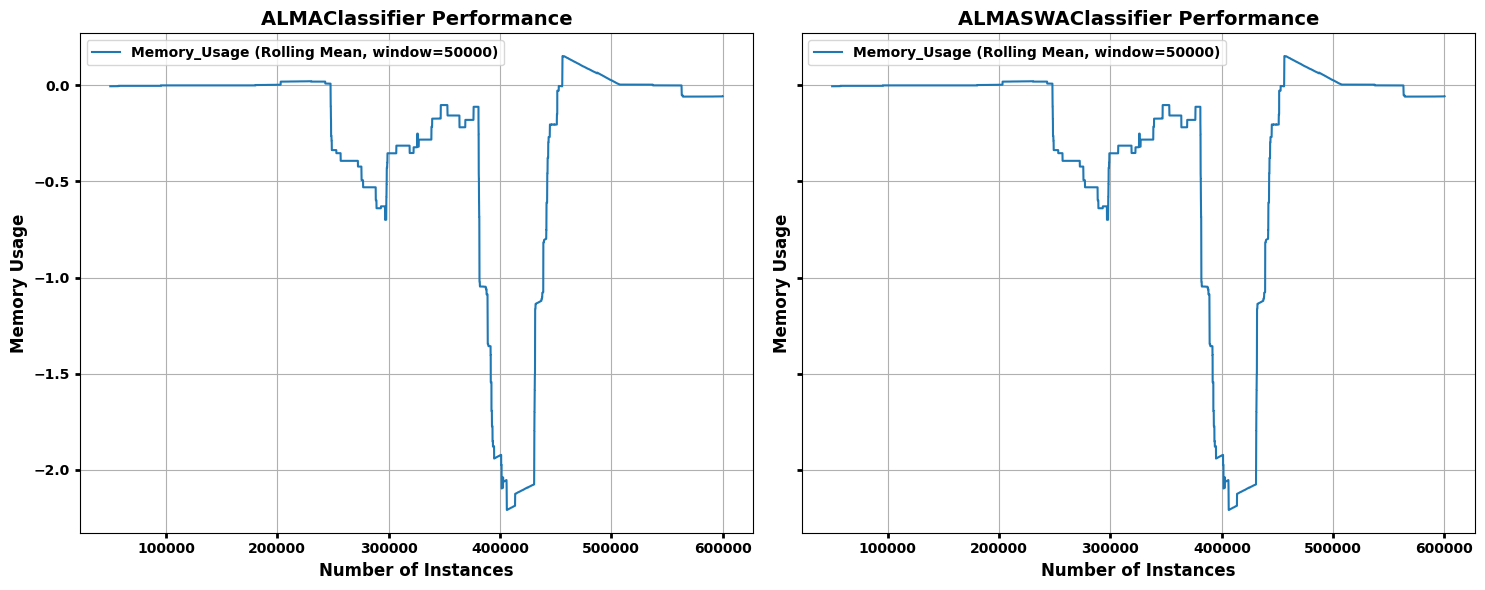

In [16]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=50000):
    metrics_names = ['Memory_Usage']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Memory Usage', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_Memory.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### Processing Time

Number of samples per class: Counter({1: 586241, 0: 13859})
Processed 100000 samples. Throughput: 11433.45 samples/sec.
Processed 200000 samples. Throughput: 11921.56 samples/sec.
Processed 300000 samples. Throughput: 12071.40 samples/sec.
Processed 400000 samples. Throughput: 11988.53 samples/sec.
Processed 500000 samples. Throughput: 11906.10 samples/sec.
Processed 600000 samples. Throughput: 11893.44 samples/sec.

Total samples processed: 600100
Total elapsed time: 50.46 seconds
Throughput: 11892.82 samples/second

--- ALMAClassifier ---
Accuracy: 0.9240
F1 Score: 0.9600
ROCAUC Score: 0.6970

--- ALMASWAClassifier ---
Accuracy: 0.9821
F1 Score: 0.9909
ROCAUC Score: 0.7273

--- ALMAClassifier Performance ---
Average Latency per Sample: 0.0242 ms
Average CPU Usage: 1.75%
Average Memory Usage: -0.25 KB
Average Total Processing Time per Sample: 0.0400 ms

--- ALMASWAClassifier Performance ---
Average Latency per Sample: 0.0225 ms
Average CPU Usage: 1.75%
Average Memory Usage: -0.25 KB
A

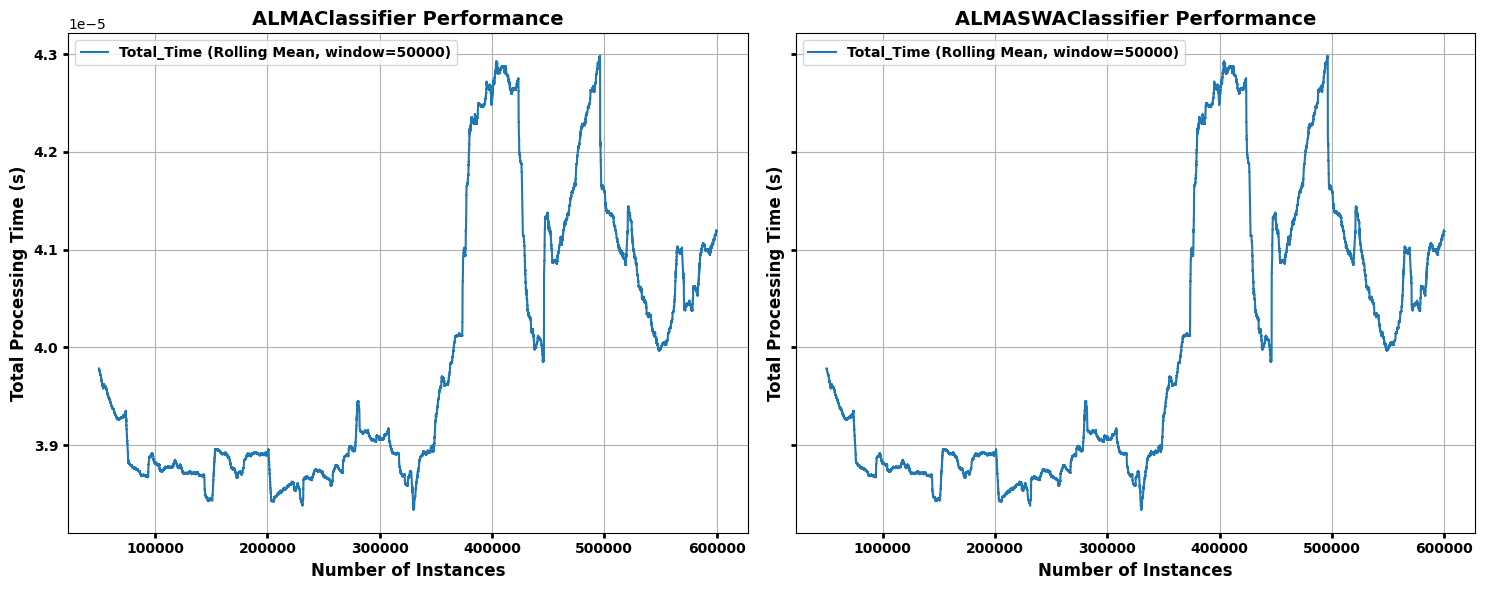

In [17]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=50000):
    metrics_names = ['Total_Time']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Total Processing Time (s)', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/BoT_Time.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

## Experiment 7: Effect of Varying SWA Frequency and SWA Start on performance

### Varying SWA Frequency


Evaluating SWA Frequency: 10
Final Recall for SWA Frequency 10: 0.9945

Evaluating SWA Frequency: 50
Final Recall for SWA Frequency 50: 0.9944

Evaluating SWA Frequency: 100
Final Recall for SWA Frequency 100: 0.9943

Evaluating SWA Frequency: 200
Final Recall for SWA Frequency 200: 0.9931

Evaluating SWA Frequency: 500
Final Recall for SWA Frequency 500: 0.9905

Evaluating SWA Frequency: 1000
Final Recall for SWA Frequency 1000: 0.9875

Evaluating SWA Frequency: 5000
Final Recall for SWA Frequency 5000: 0.9693

Evaluating SWA Frequency: 10000
Final Recall for SWA Frequency 10000: 0.9511

=== Experiment Results ===
SWA Frequency: 10 | Recall: 0.9945
SWA Frequency: 50 | Recall: 0.9944
SWA Frequency: 100 | Recall: 0.9943
SWA Frequency: 200 | Recall: 0.9931
SWA Frequency: 500 | Recall: 0.9905
SWA Frequency: 1000 | Recall: 0.9875
SWA Frequency: 5000 | Recall: 0.9693
SWA Frequency: 10000 | Recall: 0.9511

Optimal SWA Frequency: 10 with Recall: 0.9945


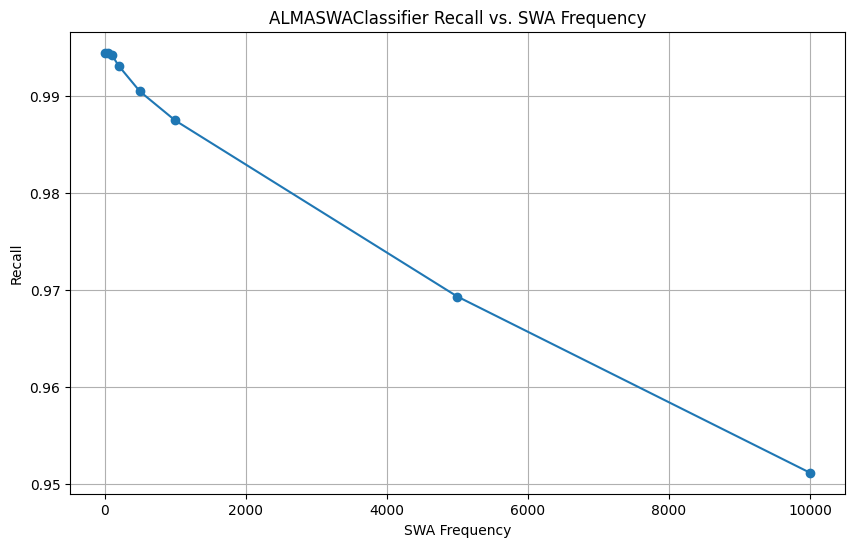

In [18]:
import pandas as pd
from sklearn.utils import shuffle
from river import compose, preprocessing, metrics, stream
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)  # Shuffle the data to ensure randomness

# Define the list of SWA frequencies to experiment with
swa_frequencies = [10, 50, 100, 200, 500, 1000, 5000, 10000]

# Initialize a dictionary to store accuracy results for each SWA frequency
recall_results = {}

# Iterate over each SWA frequency to evaluate performance
for freq in swa_frequencies:
    print(f"\nEvaluating SWA Frequency: {freq}")

    # Define the pipeline with StandardScaler and ALMASWAClassifier
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier(swa_freq=freq)
    )
    
    # Initialize the accuracy metric
    recall = metrics.Recall()
    
    # Stream the data and update the model and metric
    for xi, yi_true in stream.iter_pandas(X, y):
        y_pred = model.predict_one(xi)  # Make a prediction
        model.learn_one(xi, yi_true)    # Update the model with the true label
        recall.update(yi_true, y_pred)  # Update the accuracy metric
    
    # Store the final accuracy for this SWA frequency
    final_recall = recall.get()
    recall_results[freq] = final_recall
    print(f"Final Recall for SWA Frequency {freq}: {final_recall:.4f}")

# Identify the SWA frequency with the highest accuracy
best_freq = max(recall_results, key=recall_results.get)
best_recall = recall_results[best_freq]

print("\n=== Experiment Results ===")
for freq, rec in recall_results.items():
    print(f"SWA Frequency: {freq} | Recall: {rec:.4f}")
    
print(f"\nOptimal SWA Frequency: {best_freq} with Recall: {best_recall:.4f}")

# Optional: Plot the results for visualization
plt.figure(figsize=(10, 6))
plt.plot(list(recall_results.keys()), list(recall_results.values()), marker='o', linestyle='-')
plt.title('ALMASWAClassifier Recall vs. SWA Frequency')
plt.xlabel('SWA Frequency')
plt.ylabel('Recall')
plt.grid(True)
plt.show()


Running Experiments: 100%|████████████████████████| 5/5 [02:06<00:00, 25.21s/it]


--- ALMAClassifier ---
Accuracy: 0.9194 ± 0.0039
Recall: 0.9301 ± 0.0041


--- ALMASWAClassifier ---
Accuracy: 0.9818 ± 0.0005
Recall: 0.9942 ± 0.0005




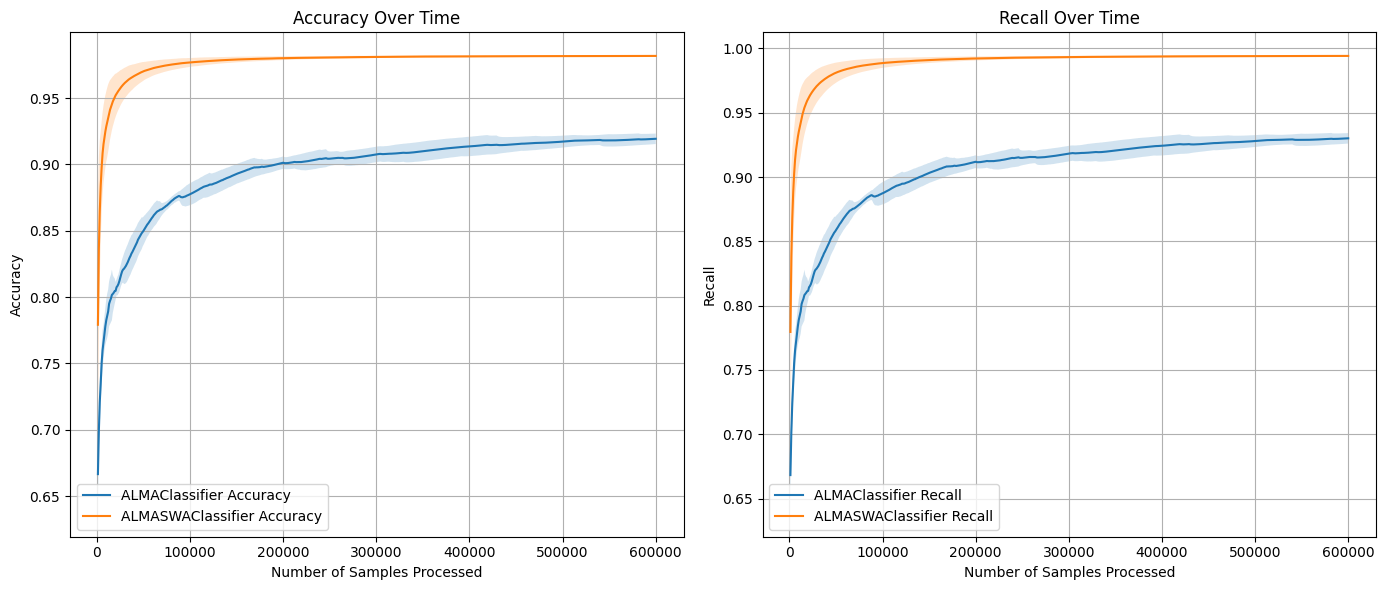

--- ALMAClassifier ---
Accuracy CV: 0.0043
Recall CV: 0.0044


--- ALMASWAClassifier ---
Accuracy CV: 0.0005
Recall CV: 0.0005




In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from river import compose, preprocessing, linear_model, metrics, stream
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Experiment Parameters
NUM_RUNS = 5  # Number of independent runs to assess variance
RANDOM_SEED = 42  # Base random seed for reproducibility
METRIC_RECORD_INTERVAL = 1000  # Record metrics every 1000 samples

# Initialize dictionaries to store metrics across runs
results = {
    'ALMAClassifier': {
        'Accuracy': [],
        'Recall': [],
        'Accuracy_over_time': [],
        'Recall_over_time': []
    },
    'ALMASWAClassifier': {
        'Accuracy': [],
        'Recall': [],
        'Accuracy_over_time': [],
        'Recall_over_time': []
    }
}

def run_experiment(run_id):
    # Set unique random state for each run for variability
    random_state = RANDOM_SEED + run_id

    # Load and prepare data
    data = pd.read_csv("/Users/promisea/SAMKNN/NF-BoT-IoT/NF-BoT-IoT.csv")
    X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
    y = data['Label']
    X, y = shuffle(X, y, random_state=random_state)
    
    # Define classifiers with their respective pipelines
    classifiers = {
        'ALMAClassifier': compose.Pipeline(
            preprocessing.StandardScaler(),
            linear_model.ALMAClassifier()
        ),
        'ALMASWAClassifier': compose.Pipeline(
            preprocessing.StandardScaler(),
            ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported
        )
    }
    
    # Initialize metrics for each classifier
    metrics_dict = {
        name: {
            'Accuracy': metrics.Accuracy(),
            'Recall': metrics.Recall()
        }
        for name in classifiers
    }
    
    # Initialize temporary storage for convergence metrics
    temp_metrics = {
        name: {
            'Accuracy_over_time': [],
            'Recall_over_time': []
        }
        for name in classifiers
    }
    
    # Iterate through the data stream and update models and metrics
    for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
        for name, model in classifiers.items():
            y_pred = model.predict_one(x)
            model.learn_one(x, true_y)
            metrics_dict[name]['Accuracy'].update(true_y, y_pred)
            metrics_dict[name]['Recall'].update(true_y, y_pred)
        
        # Record metrics at specified intervals
        if (i + 1) % METRIC_RECORD_INTERVAL == 0:
            for name in classifiers:
                temp_metrics[name]['Accuracy_over_time'].append(metrics_dict[name]['Accuracy'].get())
                temp_metrics[name]['Recall_over_time'].append(metrics_dict[name]['Recall'].get())
    
    # After the stream, collect final metrics
    for name in classifiers:
        results[name]['Accuracy'].append(metrics_dict[name]['Accuracy'].get())
        results[name]['Recall'].append(metrics_dict[name]['Recall'].get())
        results[name]['Accuracy_over_time'].append(temp_metrics[name]['Accuracy_over_time'])
        results[name]['Recall_over_time'].append(temp_metrics[name]['Recall_over_time'])

# Run the experiments multiple times
for run in tqdm(range(NUM_RUNS), desc="Running Experiments"):
    run_experiment(run)

# Compute Mean and Standard Deviation for Final Metrics
final_metrics = {}
for name in results:
    final_metrics[name] = {
        'Accuracy_Mean': np.mean(results[name]['Accuracy']),
        'Accuracy_Std': np.std(results[name]['Accuracy']),
        'Recall_Mean': np.mean(results[name]['Recall']),
        'Recall_Std': np.std(results[name]['Recall'])
    }

# Compute Mean and Std for Convergence Metrics
convergence_metrics = {}
for name in results:
    convergence_metrics[name] = {
        'Accuracy_over_time_mean': np.mean(results[name]['Accuracy_over_time'], axis=0),
        'Accuracy_over_time_std': np.std(results[name]['Accuracy_over_time'], axis=0),
        'Recall_over_time_mean': np.mean(results[name]['Recall_over_time'], axis=0),
        'Recall_over_time_std': np.std(results[name]['Recall_over_time'], axis=0)
    }

# Display Final Aggregated Results
for name, metrics_values in final_metrics.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metrics_values['Accuracy_Mean']:.4f} ± {metrics_values['Accuracy_Std']:.4f}")
    print(f"Recall: {metrics_values['Recall_Mean']:.4f} ± {metrics_values['Recall_Std']:.4f}")
    print("\n")

# Plot Convergence Over Time
# Define the number of metric recording points
num_points = len(convergence_metrics['ALMAClassifier']['Accuracy_over_time_mean'])

# Define x-axis: number of samples processed at each recording point
x_axis = [METRIC_RECORD_INTERVAL * (i + 1) for i in range(num_points)]

# Plot Accuracy Over Time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name in convergence_metrics:
    mean = convergence_metrics[name]['Accuracy_over_time_mean']
    std = convergence_metrics[name]['Accuracy_over_time_std']
    plt.plot(x_axis, mean, label=f'{name} Accuracy')
    plt.fill_between(x_axis, np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha=0.2)
plt.xlabel('Number of Samples Processed')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.grid(True)

# Plot Recall Over Time
plt.subplot(1, 2, 2)
for name in convergence_metrics:
    mean = convergence_metrics[name]['Recall_over_time_mean']
    std = convergence_metrics[name]['Recall_over_time_std']
    plt.plot(x_axis, mean, label=f'{name} Recall')
    plt.fill_between(x_axis, np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha=0.2)
plt.xlabel('Number of Samples Processed')
plt.ylabel('Recall')
plt.title('Recall Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compute Coefficient of Variation (CV) for Final Metrics
for name, metrics_values in final_metrics.items():
    accuracy_cv = metrics_values['Accuracy_Std'] / metrics_values['Accuracy_Mean']
    recall_cv = metrics_values['Recall_Std'] / metrics_values['Recall_Mean']
    print(f'--- {name} ---')
    print(f"Accuracy CV: {accuracy_cv:.4f}")
    print(f"Recall CV: {recall_cv:.4f}")
    print("\n")
